## Twitter Brand Analysis

Your company has been collecting tweets, but hasn't been using them for analysis. What do you think a business could do if they could classify tweet sentiment when sent to a company's customer service?

The dataset is from Kaggle and can be found [here.](https://www.kaggle.com/thoughtvector/customer-support-on-twitter)

### Task
Your company wants to perform an analysis on incoming tweets in order to direct tweets to the appropriate customer service teams as well as to spot the most disgruntled customers for whom proactive service is needed.

### Data content
The dataset is a CSV, where each row is a tweet. The different columns are described below. Every conversation included has at least one request from a consumer and at least one response from a company. Which user IDs are company user IDs can be calculated using the inbound field.

**tweet_id:** A unique, anonymized ID for the Tweet. Referenced by response_tweet_id and in_response_to_tweet_id.

**author_id:** A unique, anonymized user ID. @s in the dataset have been replaced with their associated anonymized user ID.

**inbound:** Whether the tweet is "inbound" to a company doing customer support on Twitter. This feature is useful when re-organizing data for training conversational models.

**created_at:** Date and time when the tweet was sent.

**text:** Tweet content. Sensitive information like phone numbers and email addresses are replaced with mask values like __email__.

**response_tweet_id:** IDs of tweets that are responses to this tweet, comma-separated.

**in_response_to_tweet_id:** ID of the tweet this tweet is in response to, if any.


### Preprocessing and cleaning
Given that we have tweet data, what kinds of preprocessing and cleaning might be necessary? What are the specific elements of tweets that we should keep in mind?
* Tweets often use abbreviations in language like "brb" or "imo"
* Tweets often use emojis and emoticons to portray emotion
* Tweets often link to URLs or have HTML tags

In addition to these special considerations, there are common text cleaning steps that we should take like:

* Making the tweets all lower case
* Remove punctuation
* Remove stopwords (see a stopword description below)
* Remove frequent and rare words from the dataset
* Stemming and/or lemmatization
* Spelling correction

In [1]:
# Let's start by importing some libraries to help in our analysis.
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
pd.options.mode.chained_assignment = None

In [2]:
twcs_raw = pd.read_csv('twcs.csv', nrows = 50000)
twcs_text = twcs_raw[["text"]]
twcs_text["text"] = twcs_text["text"].astype(str)
twcs_raw.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


### Converting to lower case
This is a common text preprocessing task. The goal is to convert the input text so that 'text', 'Text' and 'TEXT' are the same.

In [3]:
twcs_text["text_lower"] = twcs_text["text"].str.lower()

### Getting rid of punctuation
Another common text preprocessing technique is removing punctuations.

In [4]:
import string
string.punctuation

def remove_punctuation(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])# It will discard all punctuations
    return text_nopunct


twcs_text['text_wo_punct'] = twcs_text['text_lower'].apply(lambda text: remove_punctuation(text))

### Converting chat language
This is an important text preprocessing step if we are dealing with tweets since people use a lot of abbreviated words. 

The list of slang words used is from this [repo.](https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt)


In [5]:
chat_words_str = open("chat_words_str.txt").read()

list_of_cw = []
for line in chat_words_str.split("\n"):
    if line != "":
        stripped_line = line.strip()
        line_list = stripped_line.split('=')
        list_of_cw.append(line_list)
    
chat_words_map_dict = dict((cw[0], cw[1:]) for cw in list_of_cw)
chat_words_list = [cw[0] for cw in list_of_cw]

def chat_words_conversion(text):
    new_text = []
    for word in text.split():
        if word.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[word.upper()])
        else:
            new_text.append(word)
    return ' '.join(str(i) for i in new_text)

In [6]:
def chat_words_conversion(text):
    new_text = []
    for word in text.split():
        if word.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[word.upper()])
        else:
            new_text.append(word)
    return ' '.join(str(i) for i in new_text)

In [7]:
twcs_text['text_wo_chat'] = twcs_text['text_wo_punct'].apply(lambda text: chat_words_conversion(text))

### Lemmatization
The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form. 

Lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters.

‘Caring’ -> Lemmatization -> ‘Care’ ‘Caring’ -> Stemming -> ‘Car’

As a result, lemmatization is generally slower than stemming process. So depending on the speed requirement, we can choose to use either stemming or lemmatization.

In [8]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the sentence to be lemmatized
sentence = "The running dogs are jumping over the lazy foxes"

# Tokenize: Split the sentence into words
word_list = nltk.word_tokenize(sentence)

# Lemmatize list of words and join
lemmatized_output = ' '.join([lemmatizer.lemmatize(word) for word in word_list])
print(lemmatized_output)

The running dog are jumping over the lazy fox


Notice it didn’t do a good job. Because, ‘are’ is not converted to ‘be’ and ‘hanging’ is not converted to ‘hang’ as expected. This can be corrected if we provide the correct ‘part-of-speech’ tag (POS tag) as the second argument to lemmatize().

Sometimes the same word can have multiple different ‘lemma’s. So we can identify and use the ‘part-of-speech’ (POS) tag for the word in that specific context and extract the appropriate lemma.

In [9]:
print(lemmatizer.lemmatize("stripes", 'v'))  
print(lemmatizer.lemmatize("stripes", 'n'))  

strip
stripe


In [10]:
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

That's better! Now let's apply it to the entire dataset.

In [11]:
twcs_text["text_lemmatized"] = twcs_text['text_wo_chat'].apply(lambda text: lemmatize_words(text))

### Removal of stopwords
Stopwords are commonly occuring words in a language like "the" and "and". They can be removed from the text most of the times, as they don't provide valuable information. 

But when we're using Part of Speech tagging, we shouldn't remove them as they provide very valuable information about the POS. Happily, we've already performed the lemmatization so we can move forward!

These stopword lists are already compiled for different languages and we can safely use them. For example, we're using the stopword list for English.

In [12]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

twcs_text['text_wo_stop'] = twcs_text['text_lemmatized'].apply(lambda text: 
            ' '.join([word for word in text.split() if word not in (stop_words)]))

### Removal of Frequent words
In the previos step, we removed the stopwords based on English language information. But if we have a domain specific body of text (like Tweets!), we might also have some frequent words that we could consider removing.

So this step is to remove the frequent words in the given body of text. 

Let's get and then remove the most common words from this dataset.

In [13]:
from collections import Counter

cnt = Counter(" ".join(twcs_text['text_wo_stop'].astype(str)).split(" "))
print(cnt.most_common(15))

frequent_words = set([word for (word, wordcount) in cnt.most_common(15)])
print(frequent_words)

[('u', 7208), ('please', 6598), ('get', 5418), ('dm', 5105), ('help', 4692), ('hi', 3758), ('thanks', 3458), ('sorry', 3036), ('send', 2983), ('look', 2795), ('know', 2540), ('let', 2502), ('amazonhelp', 2479), ('service', 2471), ('issue', 2349)]
{'let', 'hi', 'know', 'issue', 'sorry', 'send', 'u', 'amazonhelp', 'look', 'dm', 'help', 'please', 'thanks', 'get', 'service'}


In [14]:
# now let's remove the frequent words

twcs_text['text_wo_stop'] = twcs_text['text_lemmatized'].apply(lambda text: 
            ' '.join([word for word in text.split() if word not in (stop_words)]))

In [15]:
n_rare_words = 10

rare_words = set([word for (word, wordccount) in cnt.most_common()[:-n_rare_words-1:-1]])

twcs_text['text_wo_stop'] = twcs_text['text_lemmatized'].apply(lambda text: 
                ' '.join([word for word in text.split() if word not in (stop_words)]))

In [16]:
from spellchecker import SpellChecker

#For longer words, it is highly recommended to use a distance of 1 and not the default 2. 
#This also speeds up performance.

spell = SpellChecker(distance = 1)
def spell_check(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "speling correctin"
spell_check(text)

'spelling correction'

In [17]:
twcs_text['text_w_spellcheck'] = twcs_text['text_wo_stop'].apply(spell_check)

In [18]:
twcs_text["text_lemmatized"] = twcs_text['text_w_spellcheck'].apply(lambda text: lemmatize_words(text))

### Converting emojis and emoticons
In some analyses, it's better to remove emojis and emoticons. But in tweets, they can provide us with some important information! Let's convert them to words.

In [19]:
#https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
#Importing libraries
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

In [20]:
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

text = "Hello :-) :-)"
print(convert_emoticons(text))

twcs_text['text_wo_emo'] = twcs_text['text_w_spellcheck'].apply(convert_emoticons)

Hello Happy_face_smiley Happy_face_smiley


In [21]:
import emoji

def convert_emojis(text):
    #text = str(text)
    text = emoji.demojize(text, delimiters = ("", ""))
    return text

text = "game is on 🔥 🔥"
print(convert_emojis(text))
twcs_text['text_wo_emo'] = twcs_text['text_wo_emo'].apply(convert_emojis)

game is on fire fire


### Removing URLs
A lot of tweets contain URLs that probably won't be useful to us, so let's get them out of here. 

In [22]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

text = "Driverless AI NLP blog post on https://www.h2o.ai/blog/detecting-sarcasm-is-difficult-but-ai-may-have-an-answer/"

print(remove_urls(text))

twcs_text['text_cleaned'] = twcs_text['text_wo_emo'].apply(remove_urls)

Driverless AI NLP blog post on 


In [23]:
twcs_text_cleaned = pd.DataFrame(twcs_text['text_cleaned'])
twcs_cleaned = twcs_raw.join(twcs_text_cleaned)

### Looking at the data
Now that we've got some cleaned up text, let's get an idea of the shape of our data, like the top tweeters.

In [24]:
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
%matplotlib inline
sns.set()

In [25]:
top_tweeters = twcs_cleaned.groupby('author_id', as_index=False).count().sort_values(by=['tweet_id'], ascending=False)

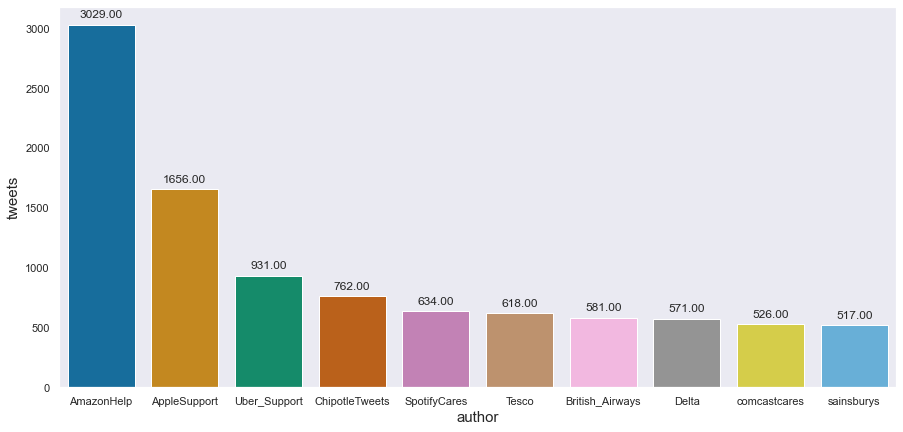

In [26]:
sns.set_style("dark")
sns.set_palette("colorblind")

f, ax = plt.subplots(figsize = (15,7))

ax = sns.barplot(x="author_id", y="tweet_id", data=top_tweeters[:10])

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xlabel("author", size=15)
plt.ylabel("tweets", size=15)
plt.show()

### Top tweeters sentiment

Let's take a look at sentiment analysis for the top tweeters.

TextBlob returns polarity and subjectivity of a sentence. Polarity lies between -1 and 1, where -1 defines a negative sentiment and 1 defines a positive sentiment. Negation words reverse the polarity. 

Subjectivity lies between 0 and 1. Subjectivity quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information. 

There's another way we can look at sentiment, which considers both polarity and subjectivity, by using nltk's SentimentIntensityAnalyzer.
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [27]:
from textblob import TextBlob

# create a function to get the subjectivity

twcs_cleaned['subjectivity'] = twcs_cleaned['text_cleaned'].apply(lambda text: TextBlob(text).sentiment.subjectivity)

In [28]:
# create a function to get the polarity

twcs_cleaned['polarity'] = twcs_text['text_cleaned'].apply(lambda text: TextBlob(text).sentiment.polarity)

In [29]:
# define a sentiment 
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [30]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentiment_analyzer = SentimentIntensityAnalyzer()

def sentiment_for(text: str) -> float:
    return sentiment_analyzer.polarity_scores(text)['compound']

sentiment_for('That is fantastic!')

0.5983

In [31]:
twcs_cleaned['sentiment'] = twcs_cleaned['text_cleaned'].apply(sentiment_for)
twcs_cleaned['tb_analysis'] = twcs_cleaned['sentiment'].apply(getAnalysis)

### Let's take a look at the sentiments in the tweets sent by the top three companies.

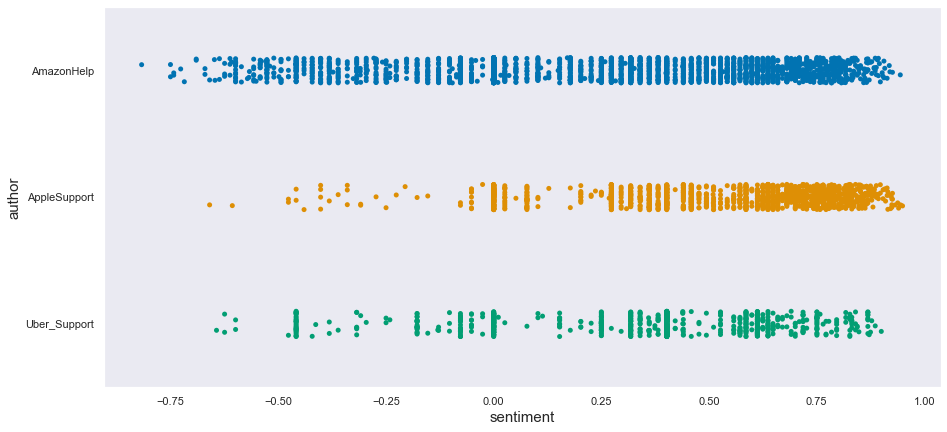

In [32]:
company_list = top_tweeters['author_id'][:3].tolist()

top_3 = twcs_cleaned[twcs_cleaned['author_id'].isin(company_list)]

sns.set_palette("colorblind")

f, ax = plt.subplots(figsize = (15,7))

ax = sns.stripplot(x="sentiment", y="author_id", data=top_3, jitter = True)

plt.xlabel("sentiment", size=15)
plt.ylabel("author", size=15)
plt.show()
plt.show()


In [33]:
first_inbound = twcs_cleaned[(pd.isna(twcs_cleaned['in_response_to_tweet_id']) == True) & (twcs_cleaned['inbound'] == True)]

responses = pd.merge(first_inbound, twcs_cleaned, left_on='tweet_id', right_on='in_response_to_tweet_id')
responses.head()

,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,text_cleaned_x,subjectivity_x,polarity_x,...,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y,text_cleaned_y,subjectivity_y,polarity_y,sentiment_y,tb_analysis_y
0,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,sprintcare bad customer service,0.666667,-0.700000,...,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0,115712 please send u private message gain far ...,0.6875,0.050,0.6908,Positive
1,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,17,NaN,115714 y’all lie “great” connection 5 bar lte ...,0.750000,0.800000,...,False,Tue Oct 31 19:59:13 +0000 2017,@115713 H there! We'd definitely like to work ...,16,18.0,115713 h wed definitely like work long experie...,0.4500,-0.025,0.6369,Positive
2,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",19,NaN,115714 whenever contact customer support tell ...,0.000000,0.000000,...,False,Tue Oct 31 22:10:10 +0000 2017,@115715 Please send me a private message so th...,NaN,20.0,115715 please send private message send link a...,0.3750,0.000,0.3182,Positive
3,29,115716,True,Tue Oct 31 22:01:35 +0000 2017,actually that's a broken link you sent me and ...,28,NaN,actually thats broken link send incorrect info...,0.250000,-0.200000,...,False,Tue Oct 31 22:05:37 +0000 2017,@115716 The information pertaining to the acco...,24,29.0,115716 information pertaining account assumpti...,0.0000,0.000,0.0000,Neutral
4,31,115717,True,Tue Oct 31 22:06:54 +0000 2017,"Yo @Ask_Spectrum, your customer service reps a...",30,NaN,yo askspectrum customer service rep super nice...,0.833333,0.466667,...,False,Tue Oct 31 22:12:09 +0000 2017,"@115717 Hello, My apologies for any frustratio...",NaN,31.0,115717 hello apology frustration inconvenience...,1.0000,0.800,-0.1779,Negative


### Let's take a look at the sentiments in the first tweets sent to the top three companies


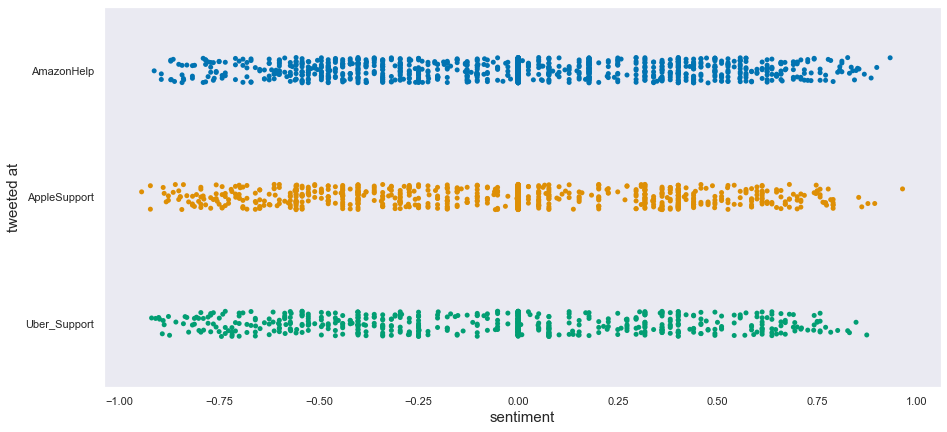

In [34]:
tweeted_at = responses[responses['author_id_y'].isin(company_list)]


sns.set_palette("colorblind")

f, ax = plt.subplots(figsize = (15,7))

ax = sns.stripplot(x="sentiment_x", y="author_id_y", data=tweeted_at, jitter = True)

plt.xlabel("sentiment", size=15)
plt.ylabel("tweeted at", size=15)
plt.show()
plt.show()

In [35]:
company_list = top_tweeters['author_id'][:20].tolist()
top_companies = responses[responses['author_id_y'].isin(company_list)]
mean_ib_sentiment = top_companies.groupby(['author_id_y'], as_index = False)['sentiment_x'].mean().sort_values(by=['sentiment_x'], ascending = False)

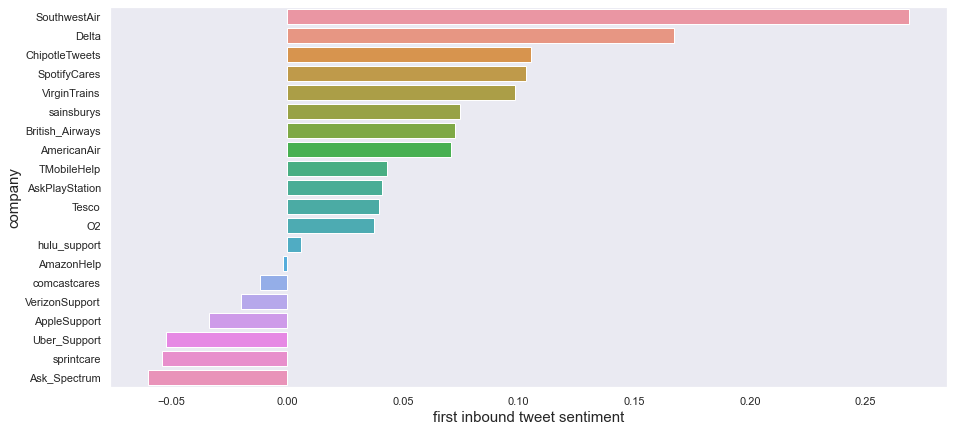

In [36]:
sns.set_palette("colorblind")
f, ax = plt.subplots(figsize = (15,7))

ax = sns.barplot(x = 'sentiment_x', y = 'author_id_y', data = mean_ib_sentiment, ci = None)

plt.xlabel("first inbound tweet sentiment", size=15)
plt.ylabel("company", size=15)
plt.show()

### Let's visualize response times and sentiment

In [37]:
# what can we say about response times?
#Changing timestamp format
responses['outbound_time'] = pd.to_datetime(responses['created_at_y'], format='%a %b %d %H:%M:%S +0000 %Y')
responses['inbound_time'] = pd.to_datetime(responses['created_at_x'], format='%a %b %d %H:%M:%S +0000 %Y')

#Calculating time between between outbound response and inbound message
responses['response_time'] = responses['outbound_time'] - responses['inbound_time']

responses['converted_time'] = responses['response_time'].astype('timedelta64[s]')

response_time = responses.groupby('author_id_y', as_index = False)['converted_time'].mean().sort_values(by='converted_time', ascending = False)
slowest_list = response_time['author_id_y'][:50].tolist()
slowest = response_time[:50]
slowest_group = responses[responses['author_id_y'].isin(slowest_list)].groupby('author_id_y', as_index=False)['sentiment_x'].mean().sort_values(by=['sentiment_x'], ascending = False)                       

slow_compare = slowest.merge(slowest_group, left_on = 'author_id_y', right_on='author_id_y')
slow_compare['response_minutes'] = slow_compare['converted_time'] / 60

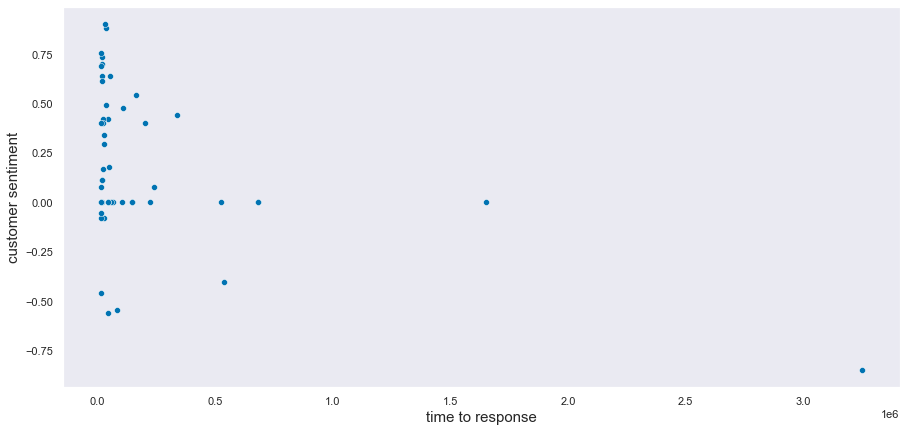

In [38]:
f, ax = plt.subplots(figsize = (15,7))

ax = sns.scatterplot(data=slow_compare, x="response_minutes", y="sentiment_x", legend="full")

plt.xlabel("time to response", size=15)
plt.ylabel("customer sentiment", size=15)
plt.show()

But can we say the slow response time was the reason for the negative sentiment? Doubtful, as the sentiment was measured for the first inbound tweet. We can at least say that perhaps the reasons for the slow response and the reasons for the negative sentiment are entertwined.

### Let's move on to our business case

As a reminder, your company wants to perform an analysis on incoming tweets in order to direct tweets to the appropriate customer service teams as well as to spot the most disgruntled customers for whom proactive service is needed.

Let's start with identifying the most disgruntled customers so your top customer support people can prioritize those responses.

Let's say we're working for Amazon due to the large number of tweets. Let's use this to prioritize our responses.

In [39]:
# We can calculate average sentiment values for each customer for the bottom company
# and compare to predefined alert threshold. 
# If the average sentiment value is lower than the threshold we'll list all the customers(author_id) 
# and suggest to reach to them for further discussion to find the reason and resolve the issues proactively

amazon = responses[responses['author_id_y'] == 'AmazonHelp']

author_sentiment_avg = amazon.groupby('author_id_x', as_index=False)['sentiment_x'].mean().rename(columns={'sentiment_x':'mean_sentiment'}).sort_values(by=['mean_sentiment'])

alert_threshold_avg = -0.7
author_sentiment_avg_df = author_sentiment_avg[author_sentiment_avg['mean_sentiment'] <= alert_threshold_avg]

author_sentiment_avg_df[:15]

,author_id_x,mean_sentiment
821,125680,-0.9136
57,116877,-0.8957
561,122370,-0.8957
592,122606,-0.8720
718,123969,-0.8706
48,116830,-0.8658
585,122595,-0.8625
251,119902,-0.8519
309,120266,-0.8436
620,122926,-0.8402


### Classifying tweets for customer service teams

Can we use the tweets to classify them as positive, negative, and neutral in order to make sure that negative and neutral customer service needs go to customer service, while positive tweets are responded to by a social media team?

In [40]:
from sklearn.preprocessing import LabelEncoder

In [41]:
tidy = twcs_cleaned[(twcs_cleaned['inbound'] == True) & (twcs_cleaned['response_tweet_id'].isnull())][['created_at', 'text_cleaned', 'tb_analysis']]
tidy['created_at'] = pd.to_datetime(tidy['created_at'])

# Assigning numerical values and storing in another column
labelencoder = LabelEncoder()
tidy['tb_analysis_cat'] = labelencoder.fit_transform(tidy['tb_analysis'])

Generally, when training a model we randomly split the data into training and testing sets. After we have trained our model, we should test it on fresh examples so that we can avoid problems like overfitting. We can also estimate how well our model is performing on new inputs.

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

Here we're going to use a bag-of-words model. It's a way of getting features out of text to use in modeling. It's simple and flexible!

It is a representation of text that involves a vocabulary of known words, and a measure of the presence of known words.

It's called a "bag" because we aren't keeping any information about word order or structure. 

First we define our vocabulary by looking at the words in the data, and then we count them to vectorize our document.

In [43]:
labels = tidy['tb_analysis_cat']
#tidy = tidy.drop('tb_analysis', axis = 1)
features = tidy.drop('tb_analysis_cat', axis = 1)

#### CountVectorizer options

**analyzerstring, {‘word’, ‘char’, ‘char_wb’} or callable, default=’word’** 
Whether the feature should be made of word n-gram or character n-grams.

For a full list of options, click [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for CountVectorizer documentation.

We call fit_transform or just fit on our original vocabulary source so that the vectorizer learns a vocabulary.

If we use fit, then you can use this fit vectorizer on any new data source using the transform() method.

There are other options, like "stop_wordsstring {‘english’}, list, default=None" which, if ‘english’, uses a built-in stop word list for English. However, since we already cleaned our text data we can move forward.

In [44]:
bow_vectorizer = CountVectorizer(analyzer = "word")
bow = bow_vectorizer.fit_transform(features['text_cleaned'])

In [45]:
train_features, test_features, train_labels, test_labels = train_test_split(bow, labels, test_size = 0.25, random_state = 42)

In [46]:
rf = RandomForestClassifier(n_estimators = 150, random_state = 11).fit(train_features, train_labels)

F-score helps to measure Recall and Precision at the same time. 

In [47]:
prediction = rf.predict(test_features)

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix


print('\n')
print("=== Classification Report ===")
print(classification_report(test_labels, prediction))
print('\n')



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.67      0.43      0.52       191
           1       0.73      0.95      0.83       336
           2       0.85      0.79      0.82       433

    accuracy                           0.77       960
   macro avg       0.75      0.72      0.72       960
weighted avg       0.77      0.77      0.76       960





### Definitions of TP, FP, TN, and FN
Let's understand what these terms mean, which we are going to use to understand ROC Curves:

**TP = True Positive** 
The model predicted the positive class correctly, to be a positive class.

**FP = False Positive**
The model predicted the negative class incorrectly, to be a positive class.

**FN = False Negative**
The model predicted the positive class incorrectly, to be the negative class.

**TN = True Negative**
The model predicted the negative class correctly, to be the negative class.

### Recall vs precision vs accuracy vs F1

**Recall** is the ratio of system generated results that correctly predicted positive observations (True Positives) to all observations in the actual class (Actual Positives). It answers the question: of all the credit card charges that are fraudulent, how many of those did the system correctly classify as fraudulent?

**Precision** is the ratio of system generated results that correctly predict positive observations (True Positives) to the system’s total predicted positive observations, both correct (True Positives) and incorrect (False Positives). So it answers the question: how many of those charges labelled by the system as fraudulent are actually fraudulent?

**Accuracy** is the ratio of the correctly predicted classifications (both True Positives + True Negatives) to the total Test Dataset. It answers the question: how many credit card charges did the system correctly classify (i.e. both True Positives or True Negatives) out of all the charges?

**The F1 Score** is the weighted average (or harmonic mean) of Precision and Recall. It takes both False Positives and False Negatives into account to strike a balance between precision and recall.

In [49]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# get false and true positive rates
probas = rf.predict_proba(test_features)
fpr, tpr, thresholds = roc_curve(test_labels, probas[:,0], pos_label=0)

# get area under the curve
roc_auc = auc(fpr, tpr)

**A typical ROC curve has False Positive Rate (FPR) on the X-axis and True Positive Rate (TPR) on the Y-axis.**

The area covered by the curve is the area between the orange line (ROC) and the axis. This area covered is AUC. The bigger the area covered, the better the machine learning models is at distinguishing the given classes. Ideal value for AUC is 1.

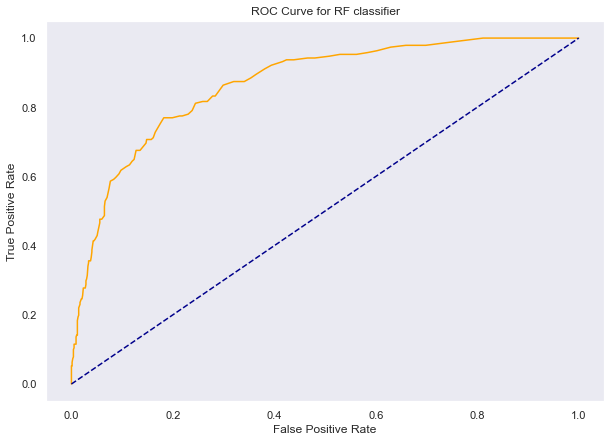

In [50]:
# plot ROC curve

plt.subplots(figsize = (10,7))

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.title('ROC Curve for RF classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.show()

### So we do a pretty good job at predicting the category. How do we do at predicting more sentiment groups so we can be better at directing customer service tweets?

In [51]:
# define a sentiment 
def getAnalysis(score):
    if score < -0.5:
        return 'Very Negative'
    elif score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    elif score < 0.5:
        return 'Positive'
    else:
        return 'Positive'

twcs_cleaned.drop('tb_analysis', axis = 1)
twcs_cleaned['tb_analysis'] = twcs_cleaned['sentiment'].apply(getAnalysis)

In [52]:
tidy = twcs_cleaned[(twcs_cleaned['inbound'] == True) & (twcs_cleaned['response_tweet_id'].isnull())][['created_at', 'text_cleaned', 'tb_analysis']]

# Assigning numerical values and storing in another column
labelencoder = LabelEncoder()
tidy['tb_analysis_cat'] = labelencoder.fit_transform(tidy['tb_analysis'])

In [53]:
labels = tidy['tb_analysis_cat']
#tidy = tidy.drop('tb_analysis', axis = 1)
features = tidy.drop('tb_analysis_cat', axis = 1)

bow_vectorizer = CountVectorizer(analyzer = "word")
bow = bow_vectorizer.fit_transform(features['text_cleaned'])

In [54]:
train_features, test_features, train_labels, test_labels = train_test_split(bow, labels, test_size = 0.25, random_state = 42)

In [55]:
rf = RandomForestClassifier().fit(train_features, train_labels)

F-score helps to measure Recall and Precision at the same time. 

In [56]:
prediction = rf.predict(test_features)

In [57]:
print('\n')
print("=== Classification Report ===")
print(classification_report(test_labels, prediction))
print('\n')



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.55      0.29      0.38       139
           1       0.72      0.96      0.82       336
           2       0.84      0.82      0.83       433
           3       0.82      0.17      0.29        52

    accuracy                           0.76       960
   macro avg       0.73      0.56      0.58       960
weighted avg       0.75      0.76      0.73       960





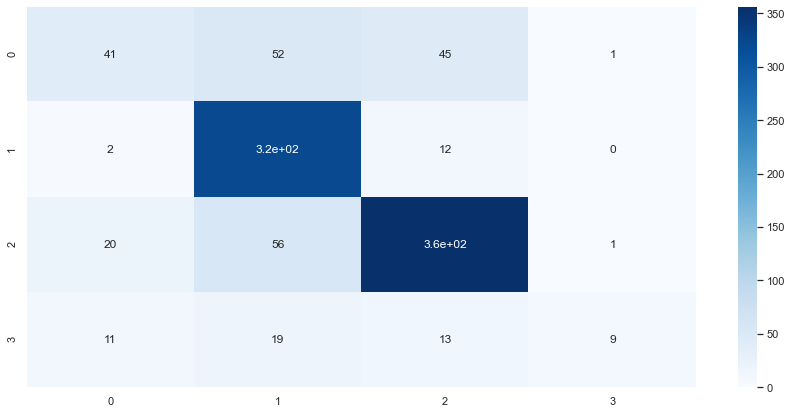

In [58]:
cm = pd.DataFrame(confusion_matrix(test_labels, prediction))

sns.set_style("dark")
sns.color_palette("light:#5A9", as_cmap=True)

f, ax = plt.subplots(figsize = (15,7))

ax = sns.heatmap(cm, annot = True, cmap = 'Blues')

plt.show()

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

print('\n')
print("=== Classification Report ===")
print(classification_report(test_labels, prediction))
print('\n')



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.55      0.29      0.38       139
           1       0.72      0.96      0.82       336
           2       0.84      0.82      0.83       433
           3       0.82      0.17      0.29        52

    accuracy                           0.76       960
   macro avg       0.73      0.56      0.58       960
weighted avg       0.75      0.76      0.73       960





In [60]:
# get false and true positive rates
probas = rf.predict_proba(test_features)
fpr, tpr, thresholds = roc_curve(test_labels, probas[:,0], pos_label=0)

# get area under the curve
roc_auc = auc(fpr, tpr)

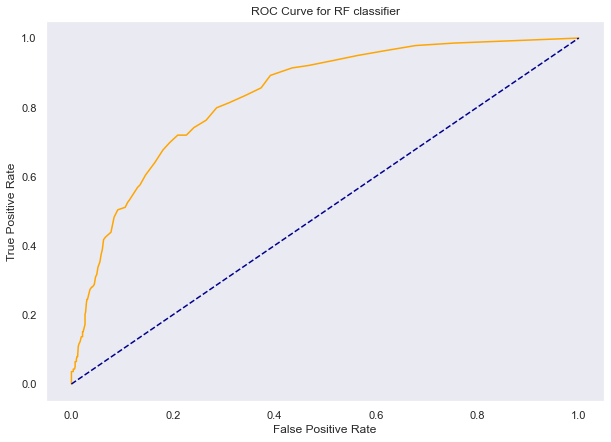

In [61]:
# plot ROC curve

plt.subplots(figsize = (10,7))

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.title('ROC Curve for RF classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.show()

Not too shabby! Looks like our predictions are better than random. We can now use them to push tweets toward the appropriate team.

### What if we wanted to look at how sentiment changed as a result of brand interaction?

In [62]:
response_company = responses[['author_id_y', 'tweet_id_y', 'in_response_to_tweet_id_y']]

last_tweet = twcs_cleaned[twcs_cleaned['created_at'] == twcs_cleaned.groupby('author_id')['created_at'].transform('max')]
last_tweet = last_tweet[last_tweet['in_response_to_tweet_id'].notnull() ]

first_last_tweet = pd.merge(first_inbound, last_tweet, on = 'author_id')
first_last_tweet = pd.merge(first_last_tweet, response_company, left_on = 'tweet_id_x', right_on = 'in_response_to_tweet_id_y')

### What is the average change in sentiment between the first and last tweets by company?

In [63]:
first_last_tweet['sentiment_change'] = first_last_tweet['sentiment_y'] - first_last_tweet['sentiment_x']

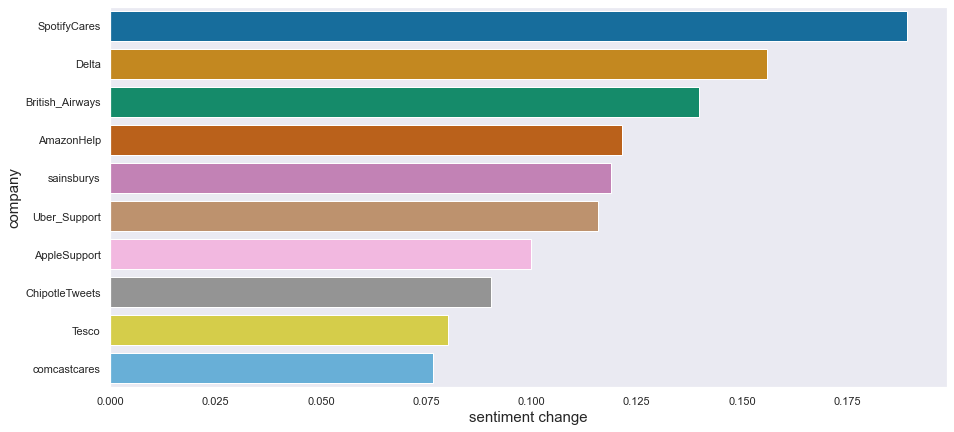

In [64]:
company_list = top_tweeters['author_id'][:10].tolist()
top_sentiment_change = first_last_tweet[first_last_tweet['author_id_y'].isin(company_list)].groupby(['author_id_y'], as_index = False)['sentiment_change'].mean().sort_values(by=['sentiment_change'], ascending = False)

sns.set_palette("colorblind")
f, ax = plt.subplots(figsize = (15,7))

ax = sns.barplot(x = 'sentiment_change', y = 'author_id_y', data = top_sentiment_change, ci = None)

plt.xlabel("sentiment change", size=15)
plt.ylabel("company", size=15)
plt.show()